In [4]:
import math
import os
import pickle
import time

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch import device
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import MulticlassAccuracy
from tqdm import tqdm

from efficient_kan.kan import KAN
from kan.KAN_batch import KAN as PyKAN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# CREATING DATASET FROM FUNCTION

In [55]:
class FunctionDataset(Dataset):
    def __init__(self, fun, length, domain_range: tuple[int, int]):
        self.fun = fun
        self.length = length
        self.domain_range = domain_range

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        return self.fun(idx / self.length * (self.domain_range[1] - self.domain_range[0]) + self.domain_range[0])

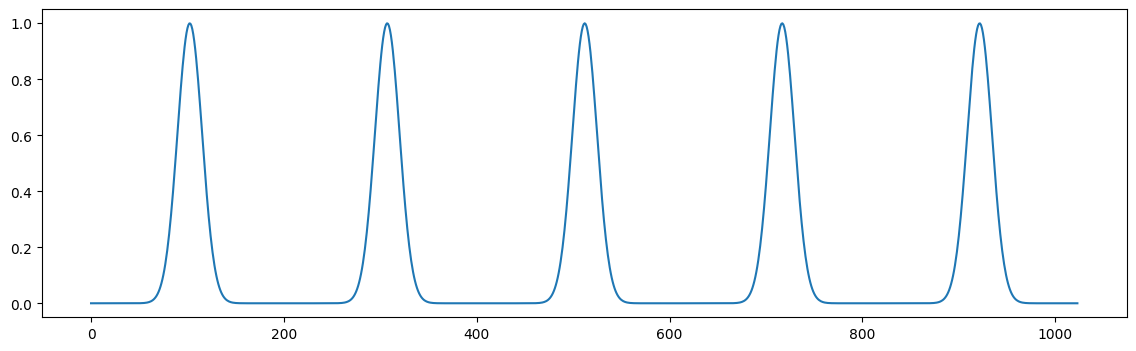

In [87]:
batch_size=64
num_batches=16
means = [-.8, -.4, 0, .4, .8]
variances = [.025, .025, .025, .025, .025]
function = lambda x: sum(
    math.exp(-(x - mean) ** 2 / (2 * variance ** 2)) for mean, variance in zip(means, variances))
dataset = FunctionDataset(fun=function, length=batch_size*num_batches, domain_range=(-1, 1))
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

plt.figure(figsize=(14, 4))
plt.plot(np.concatenate([x.numpy() for x in train_loader], axis=0))
plt.show()

In [140]:
# MLP
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = [1, 256, 256,1]
        self.fc1 = nn.Linear(self.layers[0], self.layers[1])
        self.fc2 = nn.Linear(self.layers[1], self.layers[2])
        self.fc3 = nn.Linear(self.layers[2], self.layers[3])

    def forward(self, x):
        x = x.view(-1, self.layers[0])
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [73]:
# KAN
class Efficient_KAN(nn.Module):
    def __init__(self, grid_size=30):
        super(Efficient_KAN, self).__init__()
        self.layers = [1, 1]
        self.model = KAN(self.layers, grid_size=grid_size).to(device)

    def forward(self, x):
        x = x.view(-1, self.layers[0])
        x = self.model(x)
        return x

In [74]:
class Py_KAN(nn.Module):
    def __init__(self, grid_size):
        super(Py_KAN, self).__init__()
        self.layers = [1, 1]
        self.model = PyKAN(self.layers, device=device, grid=grid_size).to(device)

    def train(self, epochs=5, on_epoch_end=None, lr=1, train_loader=None):
        self.model.train(train_loader, train_loader, lr=lr, epochs=epochs, device=device,
                         metrics=MulticlassAccuracy(num_classes=10).to(device), opt="Adam")

    def forward(self, x):
        x = x.view(-1, self.layers[0])
        x = self.model(x)
        x = F.log_softmax(x, dim=1)
        return x


# TRAIN() AND TEST() FUNCTIONS

In [125]:
def train(model, checkpoint, optimizer, start_epoch=0, epochs=5, on_epoch_end=None, lr=0, loader=None,
          task_id=None):
    if loader is None:
        loader = train_loader
    criterion = nn.MSELoss()
    for epoch in range(start_epoch, epochs + start_epoch):
        model.train()
        epoch_start = time.time_ns()
        with tqdm(loader) as pbar:
            for i, y in enumerate(pbar):
                x=torch.linspace(batch_size*i,batch_size*(i+1)-1, steps=batch_size).to(device)
                y = y.to(device)
                optimizer.zero_grad()
                output = model(x)
                loss = criterion(output.float(), y.float())
                loss.backward()
                optimizer.step(closure=lambda: loss)
                pbar.set_postfix(loss=loss.item(), lr=optimizer.param_groups[0]['lr'])
        print(f'Epoch {epoch + 1}, Loss: {loss.item()}')
        epoch_duration = (time.time_ns() - epoch_start) // 1000000
        if on_epoch_end is not None:
            on_epoch_end(model, epoch, loss.item(), epoch_duration, lr, task_id)

In [136]:
def test(model):
    model.eval()
    predictions = []
    ground_truths = []
    with torch.no_grad():
        for i, y in enumerate(train_loader):
            x=torch.linspace(batch_size*i,batch_size*(i+1)-1, steps=batch_size).to(device)
            ground_truths.extend(y.numpy())
            out=model(x).cpu()
            predictions.extend(out.view(-1).numpy())
            
    plt.figure(figsize=(14, 2))
    plt.plot(ground_truths)
    plt.plot(predictions)
    plt.show()
    return ground_truths, predictions

# INTRA and INTER DATASET TESTS
This class holds all relevant information about a training + test epoch. All the information needed to compute a confusion matrix is stored in the labels[] and predictions[] lists. Each serialised file takes about 300KiB, so they were added to the gitignore file.

In [78]:
class EpochStat:
    @staticmethod
    def loadModelStats(name, dir=f'results/gaussian_peaks/', subdir='') -> list['EpochStat']:
        return sorted([pickle.load(open(f'{dir}{subdir}{file}', 'rb')) for file in
                       filter(lambda e: name == '_'.join(e.split('_')[:-1]), os.listdir(f'{dir}{subdir}'))],
                      key=lambda e: e.epoch)

    def __init__(self, name, epoch, train_loss=0, test_loss=0, labels=None, predictions=None, epoch_duration=0, lr=0,
                 train_losses=None, train_accuracies=None, task_id=None):
        self.name = name
        self.train_loss = train_loss
        self.test_loss = test_loss
        self.epoch = epoch
        self.predictions = predictions
        self.labels = labels
        self.epoch_duration = epoch_duration
        self.lr = lr
        self.train_losses = train_losses
        self.train_accuracies = train_accuracies
        self.task_id = task_id

    def save(self, dir=f'results/gaussian_peaks/'):
        os.makedirs(dir, exist_ok=True)
        pickle.dump(self, open(f'{dir}{self.name}_epoch{self.epoch}.pickle', 'wb'))

    def get_accuracy(self):
        accuracy = 0
        for label, prediction in zip(self.labels, self.predictions):
            if label == prediction:
                accuracy += 1
        return accuracy / len(self.labels)


def onEpochEnd(model, epoch, train_loss, epoch_duration, lr, task_id):
    labels, predictions = test(model)
    (EpochStat(model.__class__.__name__, epoch, train_loss, None, labels, predictions, epoch_duration,
               lr, [], [], task_id)
     .save(
        dir=f'results/gaussian_peaks/intra/lr_{round(math.log10(lr))}/' if task_id is None else f'results/gaussian_peaks/inter/lr_{round(math.log10(lr))}/'))

## INTRA DATASET TEST

In [ ]:
for lr in [1e-2]:
    models = [Efficient_KAN(), MLP()]
    print(f'Using lr={lr} ------------------------------------')
    for model in [x.to(device) for x in models[:2]]:
        print(f'Training model={model.__class__.__name__}')
        train(model, f'results/gaussian_peaks/intra/{model.__class__.__name__}', epochs=10, start_epoch=0,
              optimizer=optim.Adam(model.parameters(), lr=lr), on_epoch_end=onEpochEnd, lr=lr)
        test(model)

## INTER DATASET TEST

In [ ]:
# for epochs, lr in zip([10], [1e-5]):
#     models = [MLP(output_size=2), Efficient_KAN(output_size=2),
#               CKAN_BN(), KANC_MLP(), NormalConvsKAN(), KKAN_Convolutional_Network(), SimpleCNN(), KANvolver()]
#     print(f'Using lr={lr} ------------------------------------')
#     for model in [x.to(device) for x in models[:2]]:
#         print(f'Training model={model.__class__.__name__}')
#         for i, task in enumerate(train_loader_tasks):
#             print(f'Training on task {i}')
#             train(model, f'results/{dataset_name}/inter/{model.__class__.__name__}', epochs=epochs,
#                   start_epoch=i * epochs, optimizer=optim.Adam(model.parameters(), lr=lr), on_epoch_end=onEpochEnd,
#                   lr=lr, loader=task, task_id=i)

In [ ]:
# # PyKAN custom training
# for lr in [1e-0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]:
#     kan = Py_KAN()
#     test(kan)
#     # kan.train(lr=lr, train_loader=train_loader_tasks[0])